### Project Settings

In [1]:
import os
import re
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import math
import seaborn as sns
import plotly.express as px


pd.options.display.float_format = '{:,.2f}'.format
# plt.rcParams['font.size'] = '22'
# plt.rcParams['axes.titlesize'] = '22'
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['date.autoformatter.day'] = '%Y-%m-%d'
plt.style.use('seaborn-whitegrid')

## Data Preparation

### Given Files

In [2]:
daily_files = os.listdir(os.path.join(os.getcwd(), 'Item Ranking', 'daily'))
weekly_files = os.listdir(os.path.join(os.getcwd(), 'Item Ranking', 'weekly'))
daily_scrape_dates = [re.sub('[^0-9]', '', x) for x in daily_files]
weekly_scrape_dates = [re.sub('[a-zA-Z.]', '', x).split("_")[3] for x in weekly_files]

print('FILE DATA:')
print(f'Count of Daily Files: {len(daily_files)}')
print(f'Count of Weekly Files: {len(weekly_files)}')
print(f'Sample daily scrape filename: {daily_files[0]}')
print(f'Sample weekly scrape filename: {daily_files[0]}')
print(f'Daily files scraped from: {daily_scrape_dates[0]} to {daily_scrape_dates[-1]}')
print(f'Weekly files scraped from: {weekly_scrape_dates[0]} to {weekly_scrape_dates[-1]}')

FILE DATA:
Count of Daily Files: 23
Count of Weekly Files: 13
Sample daily scrape filename: RAKUTEN_RANKING_20220823_daily.xlsm
Sample weekly scrape filename: RAKUTEN_RANKING_20220823_daily.xlsm
Daily files scraped from: 20220823 to 20221102
Weekly files scraped from: 20220810 to 20221102


### Data Loading and Cleaning

In [3]:
def basic_text_clean(text):
    '''
    methods: uppercase, strip whitespace in front and back of text, remove text between 【】
    replace commas with space, remove newline, remove carriage return character, remove duplicated whitespace
    '''
    text = text.lower()
    text = text.strip()
    text = re.sub(r'【.*?】', ' ', text)
    text = re.sub(',',' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = re.sub('\s+', ' ', text)

    return text


def combine_files(filepaths, periods, picklename):
    combined_df = pd.DataFrame()

    for filepath, period in zip(filepaths, periods):
        df = pd.read_excel(filepath, sheet_name='DATAIN')
        df['date_scraped'] = pd.to_datetime(period)
        df['date_scraped'] = pd.to_datetime(df['date_scraped']).dt.date
        combined_df = pd.concat([combined_df, df]).reset_index(drop=True)

    for col in combined_df.columns[0:5]:
        combined_df[col] = combined_df[col].apply(lambda x: basic_text_clean(x))

    combined_df = combined_df.rename(columns={
        '順位':'rank',
        'カテゴリ':'category',
        '店舗':'store',
        '商品名':'product_name',
        '価格':'price'
    })
    
    combined_df['rank'] = combined_df['rank'].str.replace('位', '').astype('category')
    combined_df.to_pickle(picklename)


daily_filepaths = [os.path.join(os.getcwd(), 'Item Ranking', 'daily', fname) for fname in daily_files]
weekly_filepaths = [os.path.join(os.getcwd(), 'Item Ranking', 'weekly', fname) for fname in weekly_files]

# combine_files(daily_filepaths, daily_scrape_dates, 'daily.pkl')
# combine_files(weekly_filepaths, weekly_scrape_dates, 'weekly.pkl')

### Translate and encode data

In [4]:
def translate_decode(df_daily, df_weekly):
    categories = {
    'タイヤ':'tire',
    'サマータイヤ':'summer tire',
    'スタッドレスタイヤ':'studless tire',
    'オールシーズンタイヤ':'all-season tire',
    'エンジンオイル':'engine oil',
    'バッテリー本体':'battery body',
    'コンタクトレンズ・ケア用品':'contact lens care products',
    'ソフトコンタクトレンズ':'soft contact lens',
    'カラコン・サークルレンズ':'color contact lens / circle lens',
    'ハードコンタクトレンズ':'hard contact lens',
    '洗浄・保存液':'washing / preserving solution'
}   

    df_daily['category'] = df_daily['category'].replace(categories)
    df_weekly['category'] = df_weekly['category'].replace(categories)

    le = LabelEncoder()
    items_to_encode = pd.concat([df_daily, df_weekly])['URL'].reset_index(drop=True)
    le.fit(items_to_encode)

    df_daily['unique_product_code'] = le.transform(df_daily['URL'])
    df_weekly['unique_product_code'] = le.transform(df_weekly['URL'])

    df_daily.to_pickle('daily.pkl')
    df_weekly.to_pickle('weekly.pkl')


df_daily = pd.read_pickle('daily.pkl')
df_weekly = pd.read_pickle('weekly.pkl')
# translate_decode(df_daily, df_weekly)

## Data Exploration

#### 1. What is the data made of?

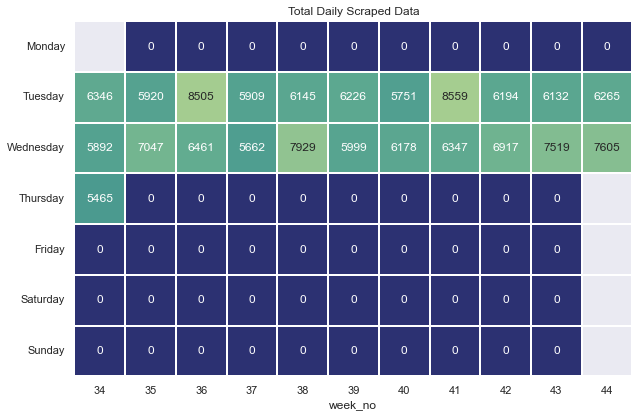

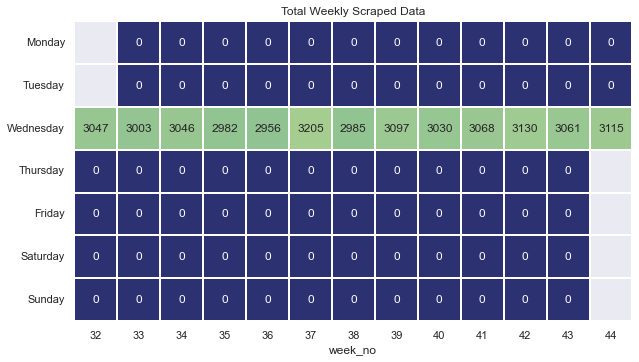

In [5]:
def count_period_totals(df, title):
    # group by date scraped
    df_period_samples = df[['date_scraped', 'unique_product_code']].set_index('date_scraped')
    df_period_samples.index = pd.to_datetime(df_period_samples.index)
    df_period_samples = df_period_samples.resample('1D').count()

    # get week_number
    df_period_samples['week_no'] = df_period_samples.index.isocalendar().week

    # # get weekday
    df_period_samples.index = df_period_samples.index.dayofweek
    df_period_samples = df_period_samples.pivot(columns='week_no',values='unique_product_code')
    df_period_samples = df_period_samples.reset_index(drop=True)

    sns.set(rc={'figure.figsize':(10,8)})
    sns.heatmap(
        df_period_samples,
        cbar=False, 
        cmap='crest_r', 
        square=True, 
        annot=True, 
        linewidth=2.,
        fmt='.0f',
        yticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    ).set(title=title)
    plt.show()


count_period_totals(df_daily, 'Total Daily Scraped Data')
count_period_totals(df_weekly, 'Total Weekly Scraped Data')

In [6]:
def plot_summary(df_summary, label='Daily'):

    df_summary = pd.pivot(df_summary, index='date_scraped', columns=['category'], values=['store', 'unique_product_code', 'price'])

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,18))
    fig.delaxes(axs[1,1])

    # plot store count
    df_summary['store'].plot.bar(
        title=f'Number of Unique Stores per Category ({label})',
        stacked=True,
        ax=axs[0,0], 
        legend=False, 
        colormap='tab20c',
        rot=45,
        xlabel=''
    )

    #plot unique_product code count
    df_summary['unique_product_code'].plot.bar(
        title=f'Number of Unique Products per Category ({label})',
        stacked=True,
        ax=axs[1,0], 
        legend=False, 
        colormap='tab20c',
        rot=45,
        xlabel=''
    )

    # plot mean price
    df_summary['price'].plot(
        kind='box',
        title='Average Price per Category',
        ax=axs[0,1],
        rot=45
    )
        
    lines = []
    labels = []
    for ax in fig.axes[:1]:
        line, label = ax.get_legend_handles_labels()
        lines.extend(line)
        labels.extend(label)

    fig.subplots_adjust(wspace=0.1)
    fig.legend(lines, labels, loc=10, bbox_to_anchor=(0.45, 0.05, 0.5, 0.5))
    plt.show()

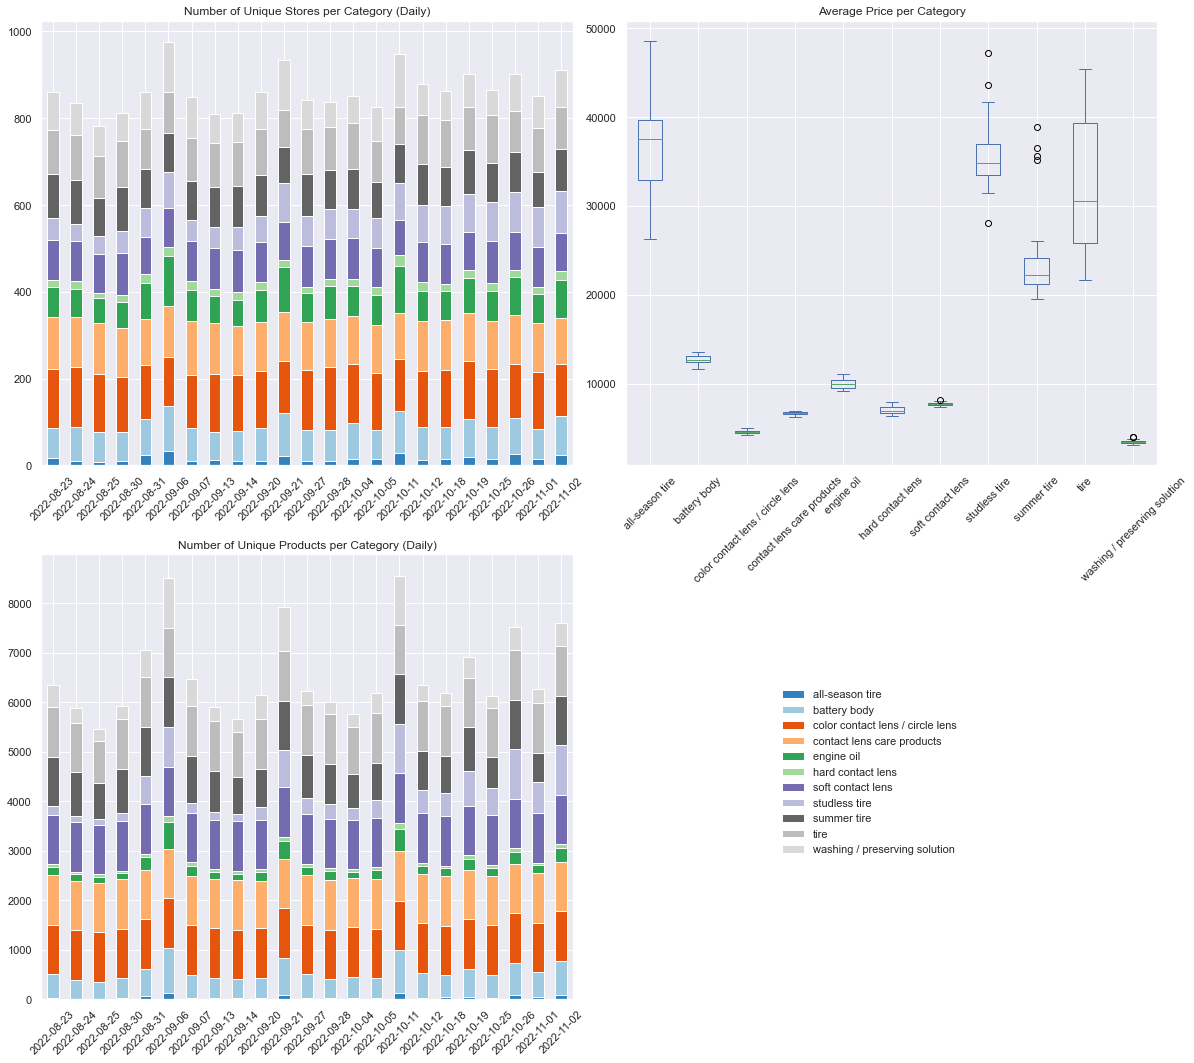

In [7]:
df_daily_summary = df_daily.groupby(['category','date_scraped']).agg({
    'store':pd.Series.nunique,
    'price':pd.Series.mean,
    'unique_product_code':pd.Series.nunique
}).reset_index()

plot_summary(df_summary=df_daily_summary, label='Daily')

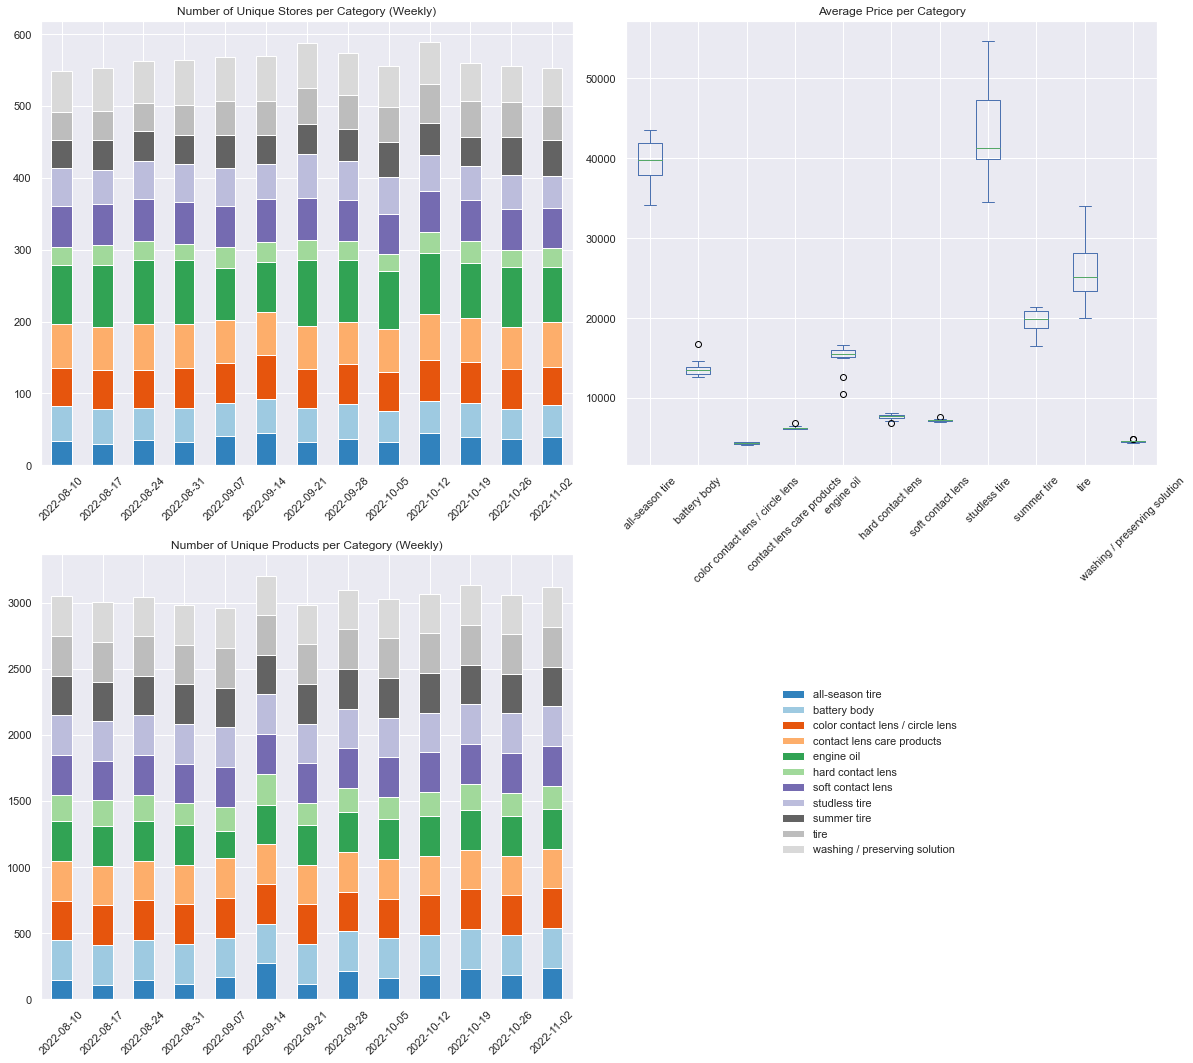

In [8]:
df_weekly_summary = df_weekly.groupby(['category','date_scraped']).agg({
    'store':pd.Series.nunique,
    'price':pd.Series.mean,
    'unique_product_code':pd.Series.nunique
}).reset_index()

plot_summary(df_summary=df_weekly_summary, label='Weekly')

#### 2. How many ranked products are retained in the ranking list by next day? 

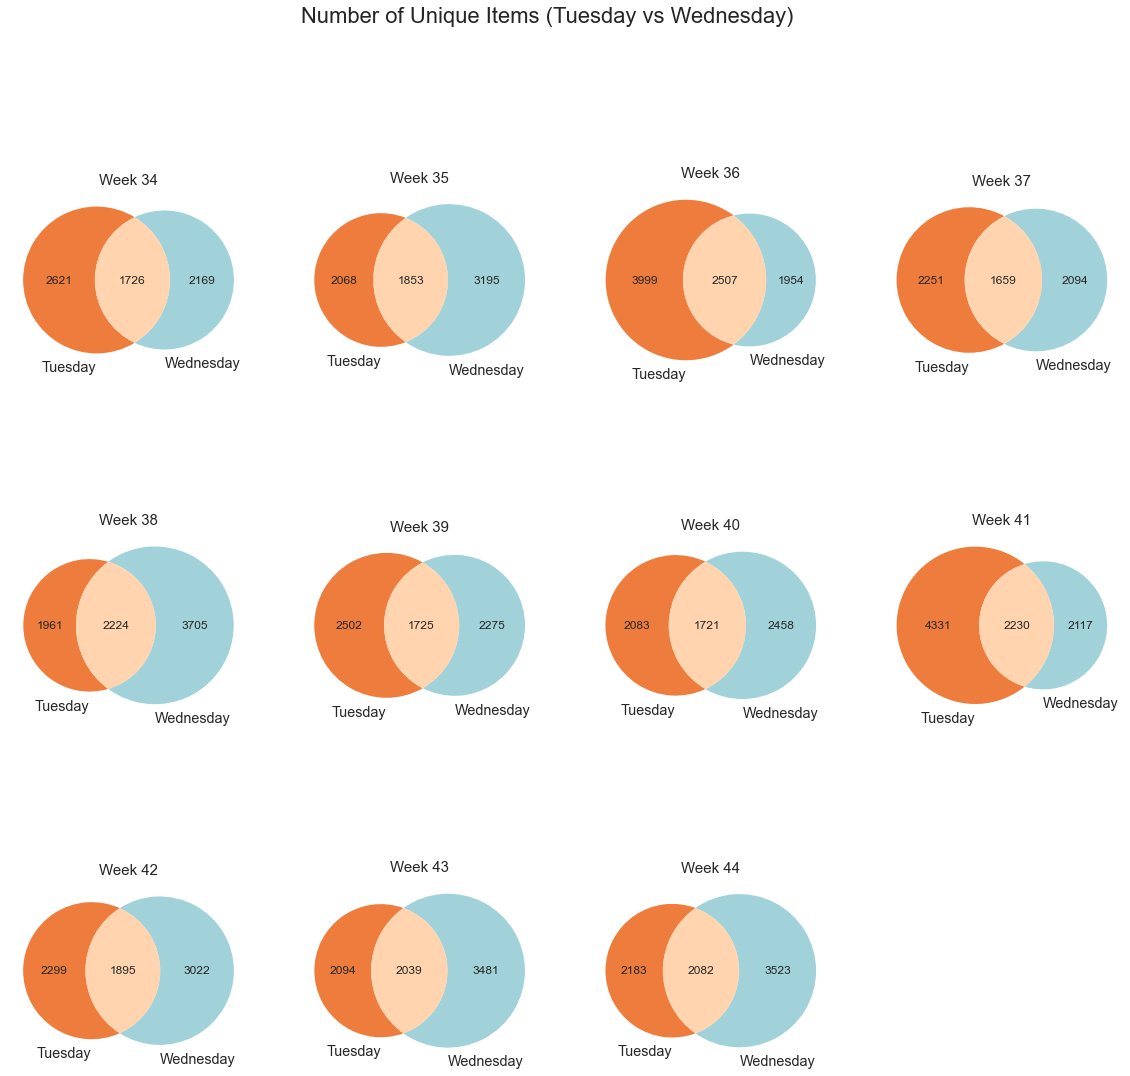

In [9]:
def plot_intersections(df_period_samples, title):

    study_periods = df_period_samples['week_no'].unique()
    nrows =int(math.floor(len(study_periods)/4)+1)

    fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(20,18))
    fig.suptitle(title,fontsize = 22)
    fig.delaxes(fig.axes[-1])
    colors = ['#EA5B0C', '#8AC6D0']

    for week_no, ax in zip(study_periods, fig.axes):
        tues_items = df_period_samples[(df_period_samples['week_no']==week_no) & (df_period_samples['day_name']=='Tuesday')]['unique_product_code']
        wed_items = df_period_samples[(df_period_samples['week_no']==week_no) & (df_period_samples['day_name']=='Wednesday')]['unique_product_code']
        venn2([set(tues_items), set(wed_items)], ('Tuesday', 'Wednesday'), ax=ax, set_colors=colors, alpha=0.8)
        ax.set_title(f'Week {week_no}', fontsize=15)


df_daily_samples = df_daily[['rank', 'category', 'date_scraped', 'unique_product_code']].set_index('date_scraped').reset_index()
df_daily_samples['day_name'] = pd.to_datetime(df_daily_samples['date_scraped']).dt.day_name()
df_daily_samples['week_no'] = pd.to_datetime(df_daily_samples['date_scraped']).dt.isocalendar().week

plot_intersections(df_daily_samples, 'Number of Unique Items (Tuesday vs Wednesday)')

#### 3. How far does one product move in ranking by the next day?

In [10]:
def plot_day_movement(df_movement, limit):  

    # filter out Tuesday and Wednesdays
    df_before = df_movement[df_movement['day_name']=='Tuesday'][['category', 'week_no', 'unique_product_code', 'rank']]
    df_after = df_movement[df_movement['day_name']=='Wednesday'][['category', 'week_no', 'unique_product_code', 'rank']]

    df_after = df_after.merge(
        df_before,
        how='inner',
        on=['category', 'week_no', 'unique_product_code'],
        suffixes = ['_wed', '_tues']
    )
    df_after['rank_tues'] = df_after['rank_tues'].astype('int')
    df_after['rank_wed'] = df_after['rank_wed'].astype('int')
    df_after['week_no'] = df_after['week_no'].astype('int')
    df_after['rank_change'] = df_after['rank_tues'] - df_after['rank_wed']
    my_filter = (df_after['rank_tues'] < limit) & (df_after['rank_wed'] < limit)

    fig = px.scatter(
        df_after[my_filter],
        x='rank_tues',
        y='rank_wed',
        title=f'Tuesday vs Wednesday rank, weekly (Top {limit})',
        color='category',
        facet_col='week_no',
        facet_col_wrap=3,
        facet_row_spacing=0.05,
        opacity=0.7,
        height=1200,
        color_discrete_sequence=px.colors.qualitative.Light24,
        template='plotly_white'
    )

    fig.add_shape(type='line', x0=0, y0=0, x1=limit, y1=limit, row=[2,3,4], col='all')
    fig.add_shape(type='line', x0=0, y0=0, x1=limit, y1=limit, row=1, col=1)
    fig.add_shape(type='line', x0=0, y0=0, x1=limit, y1=limit, row=1, col=2)

    fig.update_layout(
        legend=dict(
                title=None,
                orientation='v',
                x=0.75,
                y=-0.0,
                font={'size':12}
            )
        
    )
    fig.show()

    fig2 = px.violin(
        df_after[my_filter],
        x='rank_change',
        y='category',
        box=True,
        title=f'Summary of change in ranking from Tuesday to Wednesday (Top {limit})',
        color='category',
        height=800,
        width=800,
        color_discrete_sequence=px.colors.qualitative.Light24,
        template='plotly_white'
    )
    fig2.update_traces(showlegend=False)
    fig2.show()
    
    
plot_day_movement(df_daily_samples, limit=100)

#### 4. How many items from daily ranking make it into the weekly rankings?

In [11]:
def plot_weekly_area(df_weekly_samples, df_daily_samples):

    df_area = df_weekly_samples.drop(columns='date_scraped')
    df_area = df_area.merge(
        df_daily_samples[['rank', 'category', 'unique_product_code', 'week_no']],
        how='left',
        on=['category' , 'unique_product_code', 'week_no'],
        suffixes=['_weekly', '_daily'],
        indicator=True
    )
    df_area = df_area.rename(columns={'_merge':'from_tues_to_wed'})
    df_area['from_tues_to_wed'] = df_area['from_tues_to_wed'].replace({'left_only':'no','both':'yes'})
    
    df_product_count = df_area.groupby(['category', 'week_no', 'from_tues_to_wed']).agg({'unique_product_code':pd.Series.nunique})
    df_product_count = df_product_count.reset_index().dropna()

    fig = px.area(
        df_product_count,
        x='week_no',
        y='unique_product_code',
        color='from_tues_to_wed',
        facet_col='category',
        facet_row_spacing=0.05,
        facet_col_wrap=2,
        height=2000,
        color_discrete_sequence=px.colors.qualitative.Alphabet,
        template='plotly_white'
    )
    fig.show()

df_weekly_samples = df_weekly[['rank','category', 'date_scraped', 'unique_product_code']].set_index('date_scraped').reset_index()
df_weekly_samples['week_no'] = pd.to_datetime(df_weekly_samples['date_scraped']).dt.isocalendar().week.astype('int')
df_weekly_samples['day_name'] = pd.to_datetime(df_weekly_samples['date_scraped']).dt.day_name()

plot_weekly_area(df_weekly_samples, df_daily_samples)

#### 5. How long do products stay within the weekly ranking system?

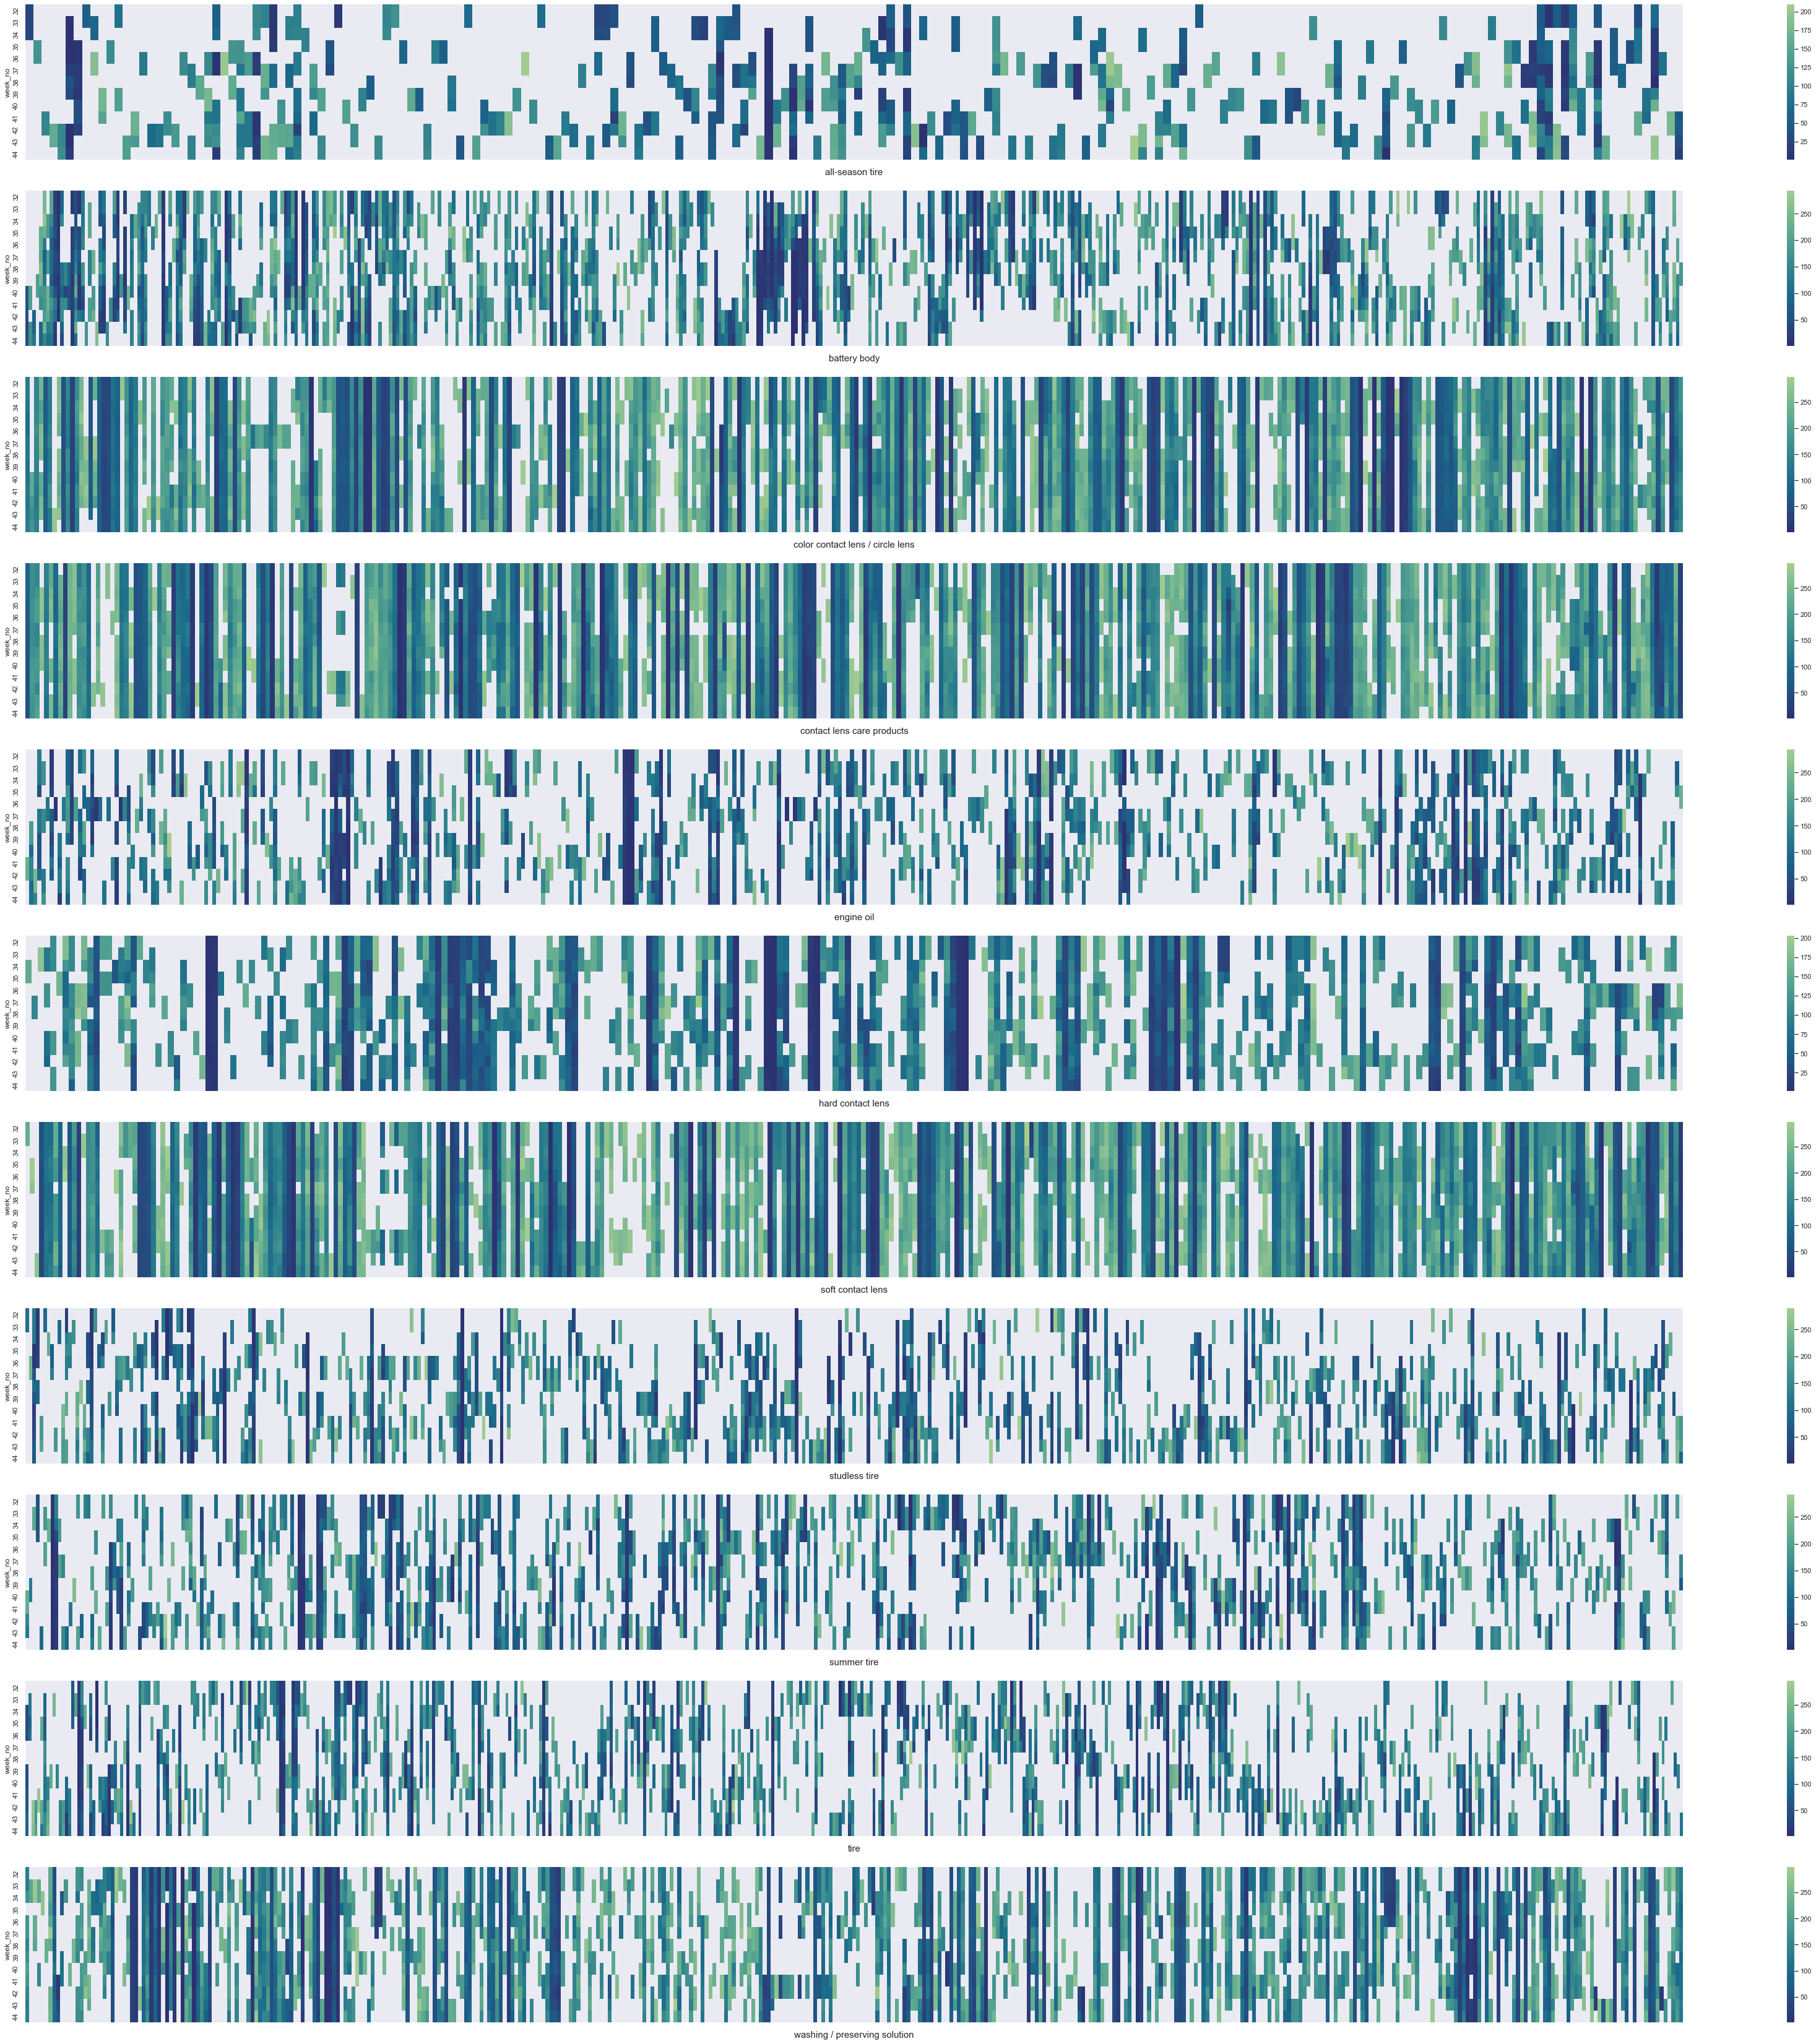

In [25]:
def map_ranking_variation(df):
    # remove the stray one values 
    df = df.rolling(window=2, axis=1).mean()
    df = df.fillna(df.shift(-1, axis=1))

    # remove rows without streak of at least 2 weeks
    df = df[df.isna().sum(axis=1)<len(df.columns)-1].reset_index()

    fig, axs = plt.subplots(nrows=11, figsize=(60,60))
    fig.suptitle(f'Weekly Ranking per Category)')

    for ax, category in zip(axs, df['category'].unique()):
        
        # isolate category to plot then transpose
        df = df[df['category']==category]
        df = df.drop(columns=['category', 'unique_product_code']).T

        sns.heatmap(
            df,
            ax=ax,
            cbar=True, 
            cmap='crest_r',
        ).set(xticklabels=[])
        ax.set_xlabel(xlabel = category, fontsize=13)


# pivot table (product code vs weeks)
df_list_life = df_weekly_samples[['rank','category', 'unique_product_code', 'week_no']].sort_values(['category', 'unique_product_code'])
df_list_life['rank'] = df_list_life['rank'].astype('int')
df_list_life = df_list_life.pivot(index=['category', 'unique_product_code'], columns='week_no', values='rank')

# encode categories
le_categ = LabelEncoder()
le_categ.fit(df_list_life.index.get_level_values(level=0).unique())

map_ranking_variation(df_list_life)


#### 6. Are there stores that make the ranking list more than once (different products)? 

#### 7. How many stores make the ranking list more than one week?

#### 8. How long do consistently ranking stores make the list?

#### 9. Does price factor in when it comes to ranking?